In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *

sampling_indices = (3, 4)

## Generate many objects in parallel

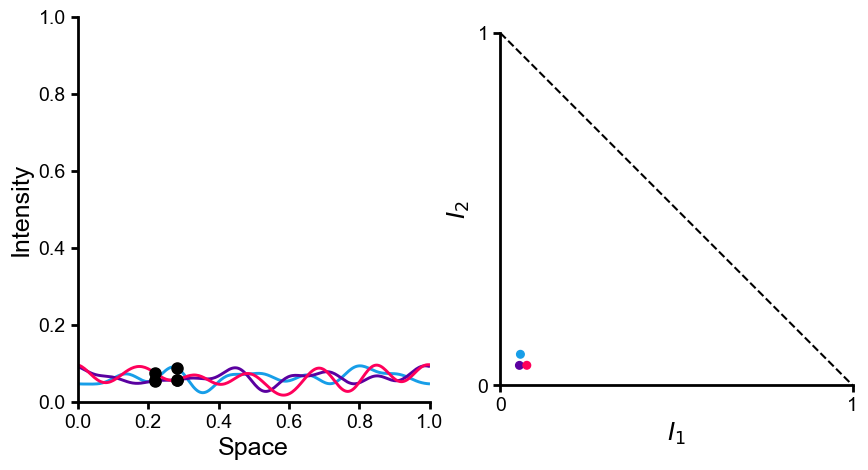

In [22]:
n_objects = 20
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])

# generate random convolution kernel
random_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
conv_mat = make_convolutional_encoder(random_kernel)

output_signals = objects @ conv_mat.T 


sampling_indices = (3, 4)
num_to_plot = 3

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], output_signals[:num_to_plot], sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], output_signals[:num_to_plot], sample_point_indices=sampling_indices, differentiate_colors=True)

## Show example objects

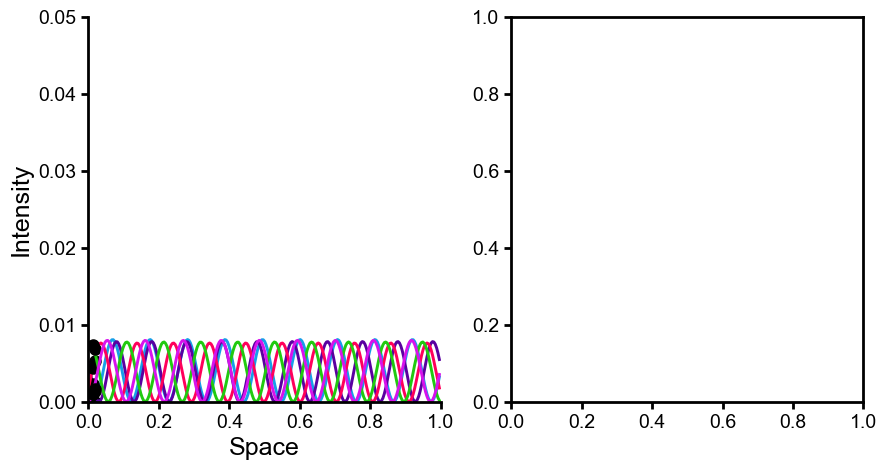

In [65]:
n_objects = 5
objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(n_objects)])

# plot all the objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], objects, sample_point_indices=sampling_indices, plot_lim=0.05)

# Optimize an encoder based on entropy as a loss function

initial loss 191.71610527043362


Text(0.5, 1.0, 'Object')

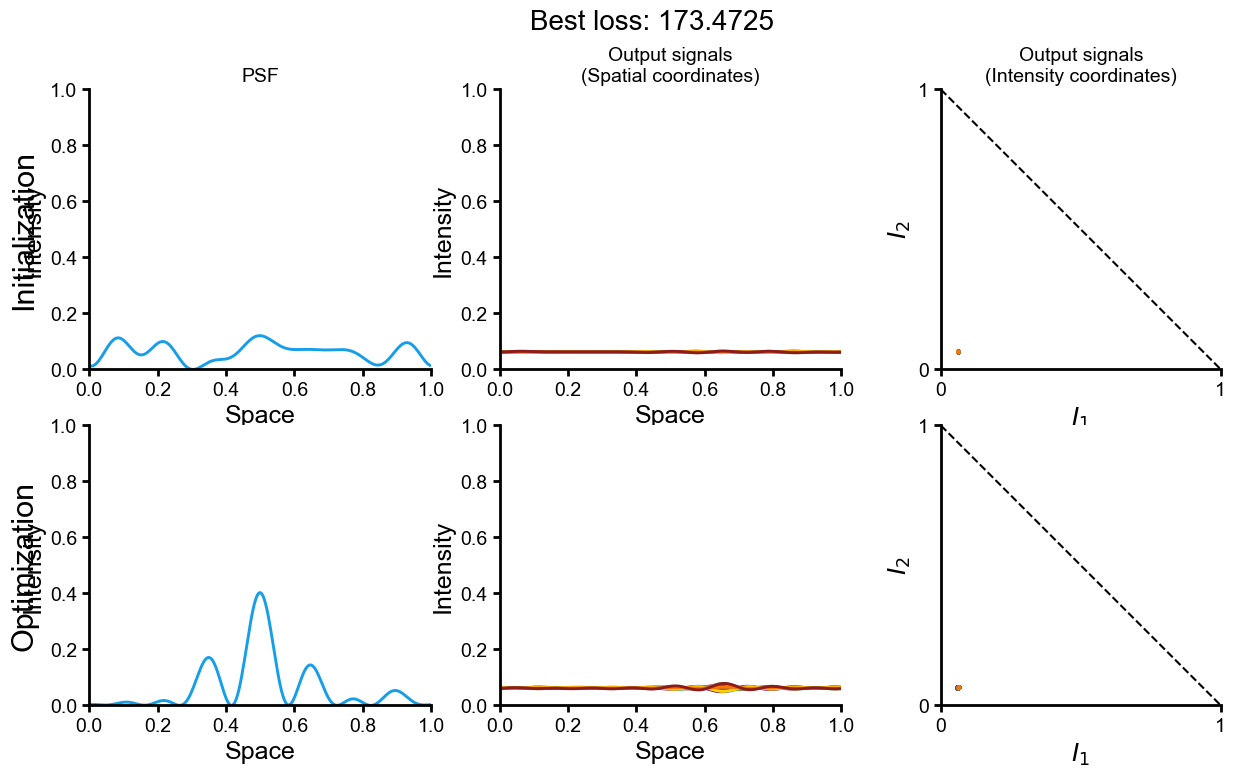

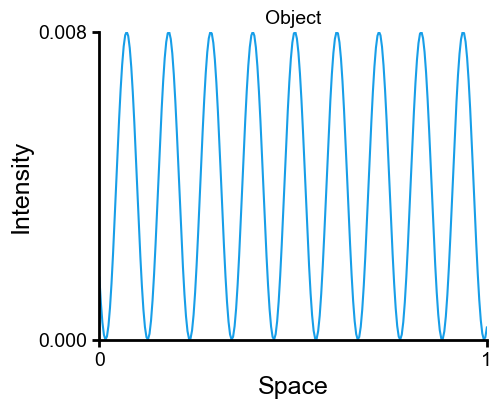

In [68]:
from encoding_information.models.gaussian_process import *

N_objects = 2000
N_objects_to_plot = 1
N_signals_to_plot = 10

# objects = np.array([sample_amplitude_object('delta', num_deltas=8) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('pink_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('white_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_amplitude_delta') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_pairs') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta_in_some_places') for i in range(N_objects)])
objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(N_objects)])


def make_convolutional_forward_model_and_entropy_loss_fn(input_signals):
    @jit
    def convolve_and_loss(parameters):
        real = parameters[:NUM_NYQUIST_SAMPLES // 2 + 1]
        imag = parameters[NUM_NYQUIST_SAMPLES // 2 + 1:]
        kernel = signal_from_real_imag_params(real, imag)
        conv_mat = make_convolutional_encoder(kernel)
        output_signals = (input_signals @ conv_mat.T)

        cov_mat = estimate_full_cov_mat(output_signals)
        eig_vals = np.linalg.eigvalsh(cov_mat)
        log_evs = np.log(eig_vals)

        return -np.sum(log_evs[1:])
        
    return convolve_and_loss


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())

loss_fn = make_convolutional_forward_model_and_entropy_loss_fn(objects)
optimized_params = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                         np.concatenate(real_imag_params_from_signal(initial_kernel)),
                           learning_rate=1e-4, learning_rate_decay=0.999,
                           verbose=True,
                         loss_improvement_patience=2000, max_epochs=10000)
optimized_loss = loss_fn(optimized_params)
optimized_kernel = signal_from_real_imag_params(*param_vector_to_real_imag(optimized_params))

# make the convolutional encoder from the optimized kernel
optimized_conv_mat = make_convolutional_encoder(optimized_kernel)
initial_conv_mat = make_convolutional_encoder(initial_kernel)



# plot the initial and optimized convolutional encoders
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

plot_in_spatial_coordinates(ax[0, 0], initial_kernel, show_samples=False, center=True)
plot_in_spatial_coordinates(ax[1, 0], optimized_kernel, show_samples=False, center=True)
ax[0,0].set_title('PSF')


ax[0, 0].text(-0.15, 0.5, 'Initialization', transform=ax[0, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)           
ax[1, 0].text(-0.15, 0.5, 'Optimization', transform=ax[1, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)       

# plot the output signals
plot_in_spatial_coordinates(ax[0, 1], objects[:N_signals_to_plot] @ initial_conv_mat.T, show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], objects[:N_signals_to_plot] @ optimized_conv_mat.T, show_samples=False)
ax[0,1].set_title('Output signals\n(Spatial coordinates)')

# plot the output signals in intensity coordinates
plot_in_intensity_coordinates(ax[0, 2], objects @ initial_conv_mat.T, markersize=5, differentiate_colors=True)
plot_in_intensity_coordinates(ax[1, 2], objects @ optimized_conv_mat.T, markersize=5, differentiate_colors=True)
ax[0,2].set_title('Output signals\n(Intensity coordinates)')
fig.suptitle(f'Best loss: {optimized_loss:.4f}', fontsize=20)


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_object(ax, objects[:N_objects_to_plot])
ax.set_title('Object')


## TODO: unclear what "samples" is supposed to be here

In [7]:
objects = np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(100000)])
output_signals = objects @ optimized_conv_mat.T
output_signals_intensity_samples = output_signals[:, sampling_indices]

# Find min and max values greater than 0
min_val = min(output_signals_intensity_samples[output_signals_intensity_samples > 0].min(), samples[samples > 0].min())
max_val = max(output_signals_intensity_samples.max(), samples.max())

# Create an array of evenly spaced bin edges within this range
bins = np.linspace(min_val, max_val, 29)  # 29 points for 28 bins

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Use bins in hist2d
h = ax[0].hist2d(output_signals_intensity_samples[:, 0], output_signals_intensity_samples[:, 1], 
              bins=[bins, bins], cmap='inferno', density=True)

default_format(ax[0])
cbar = plt.colorbar(h[3], ax=ax[0], ticks=[])
cbar.set_label('Probability', rotation=90, labelpad=15)  # Add the label to the colorbar

mean = np.mean(output_signals_intensity_samples, axis=0)
cov = np.cov(output_signals_intensity_samples.T)
samples = onp.random.multivariate_normal(mean, cov, size=100000)

# Use bins in hist2d
h = ax[1].hist2d(samples[:, 0], samples[:, 1], bins=[bins, bins], cmap='inferno', density=True)


NameError: name 'samples' is not defined

# Do it with intensity space histograms instead

initial loss 43.425224


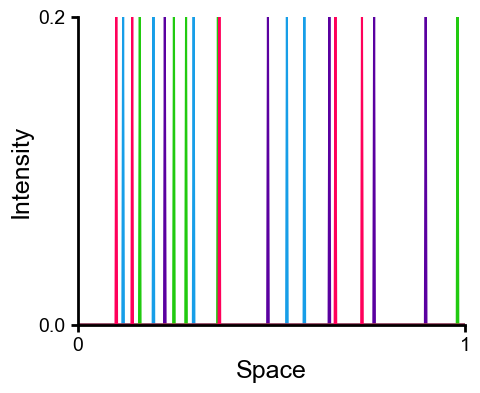

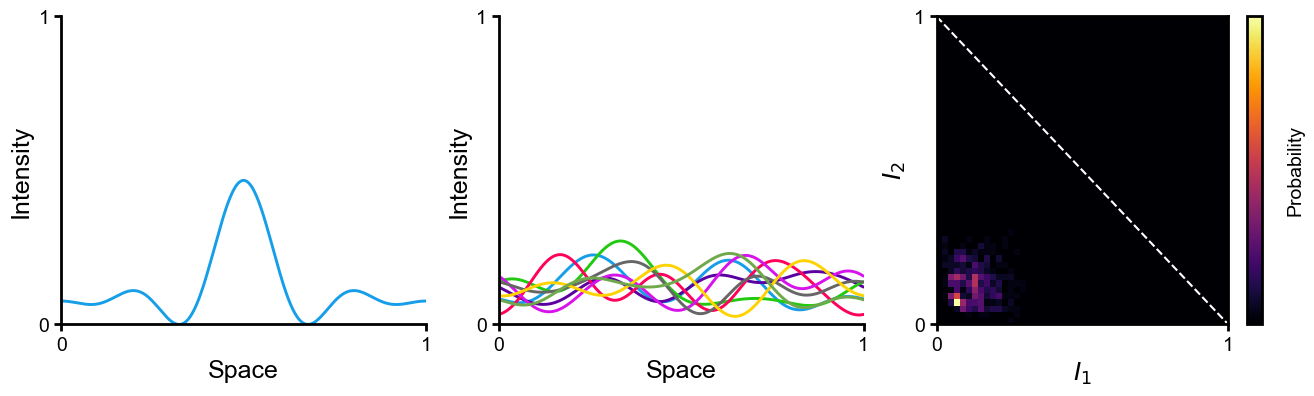

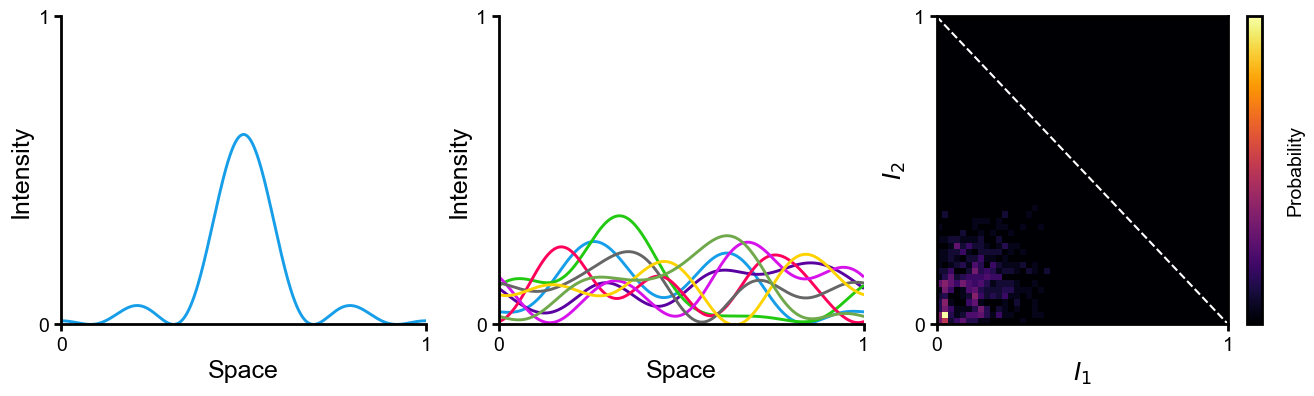

: 

In [5]:
N_objects = 500
N_objects_to_plot = 4
N_signals_to_plot = 8

objects = np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(N_objects)])

# objects = np.array([sample_amplitude_object('pink_noise', num_deltas=2) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('white_noise', num_deltas=2) for i in range(N_objects)])


def make_convolutional_forward_model_and_entropy_loss_fn(input_signals):
    @jit
    def convolve_and_loss(parameters):
        real = parameters[:NUM_NYQUIST_SAMPLES // 2 + 1]
        imag = parameters[NUM_NYQUIST_SAMPLES // 2 + 1:]
        kernel = signal_from_real_imag_params(real, imag)
        conv_mat = make_convolutional_encoder(kernel)
        output_signals = (input_signals @ conv_mat.T)
        return -nearest_neighbors_entropy_estimate(output_signals, k=10)
        
    return convolve_and_loss


initial_kernel = generate_concentrated_signal((0,1))
# initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())

loss_fn = make_convolutional_forward_model_and_entropy_loss_fn(objects)
optimized_params = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                         np.concatenate(real_imag_params_from_signal(initial_kernel)), learning_rate=1e-7, verbose=True,
                         loss_improvement_patience=2000)
optimized_kernel = signal_from_real_imag_params(*param_vector_to_real_imag(optimized_params))

# make the convolutional encoder from the optimized kernel
optimized_conv_mat = make_convolutional_encoder(optimized_kernel)
initial_conv_mat = make_convolutional_encoder(initial_kernel)


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_object(ax, objects[:N_objects_to_plot])
# ax.set_title('Object')

# plot the initial and optimized convolutional encoders
fig_initial, ax_initial = plt.subplots(1, 3, figsize=(16, 4))
fig_optimized, ax_optimized = plt.subplots(1, 3, figsize=(16, 4))

for kernel, ax, conv_mat in zip([initial_kernel, optimized_kernel], [ax_initial, ax_optimized], [initial_conv_mat, optimized_conv_mat]):
    plot_in_spatial_coordinates(ax[0], kernel, show_samples=False, center=True)
    # ax[0].set_title('Point spread function')

    plot_in_spatial_coordinates(ax[1], objects[:N_signals_to_plot] @ conv_mat.T, show_samples=False)
    # ax[1].set_title('Convolved signals')

    # plot_in_intensity_coordinates(ax[2], objects @ initial_conv_mat.T, markersize=5, differentiate_colors=True)
    plot_intensity_coord_histogram(ax[2], objects @ conv_mat.T)
    sparse_ticks(ax[2])

